# A quick implementation to perform localization task

A localization task finds object(s) in a given image and the model usually generates some attributes to the bounding boxes as output. Here, we format our ground truth to be (x, y, width, height) where x, y is the min point of the bounding boxes and width, height are the lengths to the side of the bounding boxes. In addition, we attempt to rescale the attributes to make it suitable for our chosen model's input size with a scalar value of (model's input shape / image shape). This is in response to the image downsampling required for fitting/training of the model. Then, the rest of the image preprocessing steps will be very similar to the general approaches. 

For the feature extractor, we are allowed to use any pretrained SOTA classification models to encode our image features. Since we are only interested in demonstrating the implementation of the model and not chasing for any accuracy, we will use the VGG network to build our machine.

In this implementation, we used the chest radiograph images from the kaggle competition (SIIM-ACR-Pneumothorax) and Dr Konya's hand drawn ground truth boxes that locate the chest of a patient. Our task is to locate the chest for the rest of the patients. This ends up as a regression problem.

* Evaluating metrics :: IOU
* Model optimized with loss :: Smooth L1 

**NOTE ::** Localization is slightly different from object detection as a prior to the number objects in the image is known. Thus, the machine is simplfied to predicting that bounding boxes.

In [2]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os 
import cv2
import seaborn as sns
plt.style.use('ggplot')

os.environ["CUDA_VISIBLE_DEVICES"]= "3"
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess=tf.Session(config = config)

# set seed
np.random.seed(609)
tf.random.set_random_seed(610)

## Load dataset

Total number of labelled bounding boxes ::  1000 

Number of sample size (Train) ::  800
Number of sample size (Valid) ::  200 



,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,1.2.276.0.7230010.3.1.4.8323329.300.1517875162...,420519,{},1,0,"{""name"":""rect"",""x"":214,""y"":171,""width"":740,""he...",{}
1,1.2.276.0.7230010.3.1.4.8323329.301.1517875162...,425620,{},1,0,"{""name"":""rect"",""x"":161,""y"":54,""width"":745,""hei...",{}
2,1.2.276.0.7230010.3.1.4.8323329.302.1517875162...,398688,{},1,0,"{""name"":""rect"",""x"":40,""y"":39,""width"":893,""heig...",{}
3,1.2.276.0.7230010.3.1.4.8323329.303.1517875162...,395720,{},1,0,"{""name"":""rect"",""x"":100,""y"":69,""width"":861,""hei...",{}
4,1.2.276.0.7230010.3.1.4.8323329.304.1517875162...,421197,{},1,0,"{""name"":""rect"",""x"":100,""y"":100,""width"":837,""he...",{}


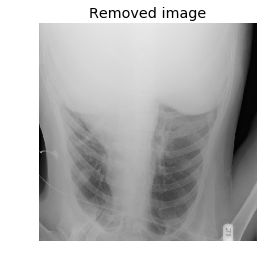

In [3]:
from sklearn.model_selection import train_test_split
root_dir = '/data/volume03/kaggle'
datacsv = pd.read_csv(os.path.join(root_dir, 'original_boundingbox.csv'))

## remove flipped image
datacsv = datacsv[datacsv.filename != '1.2.276.0.7230010.3.1.4.8323329.1649.1517875168.754818.jpg']
im = cv2.imread(os.path.join(root_dir, 'train_stage2/image/1.2.276.0.7230010.3.1.4.8323329.1649.1517875168.754818.png'))
plt.imshow(im)
plt.title('Removed image')
plt.grid(False)
plt.axis('off')

## splitting data into train & validation set (80/20)
traincsv, validcsv = train_test_split(datacsv, test_size=0.20, random_state=609)

print('Total number of labelled bounding boxes :: ', datacsv.shape[0], '\n')
print('Number of sample size (Train) :: ', len(traincsv))
print('Number of sample size (Valid) :: ', len(validcsv), '\n')

## showing the first 5 samples of the dataframe
datacsv.head()

# Comment :: The column name for the target label is 'region_shape_attributes' and it is in the format of (xmin, ymin, width, height)

## Define data generator

In [4]:
import random
import re
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from albumentations import (
    Compose, HorizontalFlip, CLAHE, OneOf, Resize, Normalize, 
    RandomBrightness, RandomContrast, RandomGamma, ToFloat,
    ShiftScaleRotate,GridDistortion, ElasticTransform,
    RandomBrightness, RandomContrast, OpticalDistortion)

## imagenet mean and std
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

np.random.seed(123)

## data augmentors
def get_transforms(phase, mean=mean, std=std):
    
    """
    Augmentation list for training ::
        Horizontal flip (perform outside of augmentor)
        Random Brightness
        Random contrast
        Normalize with imagenet mean, std
    """
    if phase == 'train':    
        augmentation_list = Compose([
            
            # random brightness
            RandomBrightness(p=0.35),
            
            # random contrast
            OneOf([RandomContrast(limit=0.5),
                   RandomGamma(),
                   CLAHE(clip_limit=2.0)], p=0.3),
        
            # normalise image
            Normalize(mean=mean,std=std, p=1),
            ToFloat()])     
    
    elif phase == 'test':
        augmentation_list = Compose([
            Normalize(mean=mean, std=std, p=1),
            ToFloat()])
    else:
        return 'No such augmenting option. i.e. phase can only be "train" or "test"' 

    return augmentation_list


## data generator
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, csvtable, image_size=512,
                 batch_size=32,
                 augmentations=get_transforms(phase='train', mean=mean, std=std),
                 shuffle=True):
        
        super(DataGenerator, self).__init__()
        
        ## get image filenames
        self.fname = csvtable['filename'].reset_index(drop=True)
        
        ## make hashtable for target
        self.target = csvtable[['filename',
                                'region_shape_attributes']].set_index(keys='filename').to_dict()
        self.image_size = image_size
        self.batch_size = batch_size
        self.transforms = augmentations
        self.shuffle = shuffle
    
        self.on_epoch_end()
    
    
    def __len__(self):
        num_steps = len(self.fname) // self.batch_size
        return num_steps
        
        
    def on_epoch_end(self):
        # Shuffle dataset for next epoch
        self.indices = np.arange(len(self.fname))
        
        if self.shuffle:
            np.random.shuffle(self.indices)

        
    def __getitem__(self, index):
        
        batch_indices = self.indices[index * self.batch_size:(index+1) * self.batch_size]
        batch_fnames = self.fname[batch_indices] 
        
        ## make images
        im, labs = [], []
        for idx, fname in enumerate(batch_fnames):
            img, lab = self.imread(fname)
            augmented = self.transforms(image=img)
            imProcessed = augmented['image']
            
            ## horizontal flip
            if random.randint(0, 1):
                imProcessed = np.flip(imProcessed, axis=1)
                lab[0] = self.image_size - (lab[0] + lab[2])
                
            im.append(cv2.resize(imProcessed, (self.image_size, self.image_size)))
            ## make labels
            labs.append(lab)

        return np.array(im), np.float32(labs)
    
    
    # read image and get target
    def imread(self, fname):
        
        ## Our images are formatted in png, thus edit fnames before reading
        fn_png = os.path.splitext(fname)[0] + '.png'
        fpath = os.path.join(root_dir, 'train_stage2/image', fn_png)
        im = cv2.imread(fpath)
        
        ## get label
        im_width, im_height = im.shape[:-1]
        lab = self.target['region_shape_attributes'][fname].split(',')
        xmin, ymin, width, height = (int(re.findall(r'\d+', lab[i])[0]) for i in range(1,len(lab)))
        
        # normalizing to scale
        xmin *= (self.image_size / im_width)
        ymin *= (self.image_size / im_height)
        width *= (self.image_size / im_width)
        height *= (self.image_size / im_height)
        
        return im, [xmin, ymin, width, height]

## Visualizing our data generator

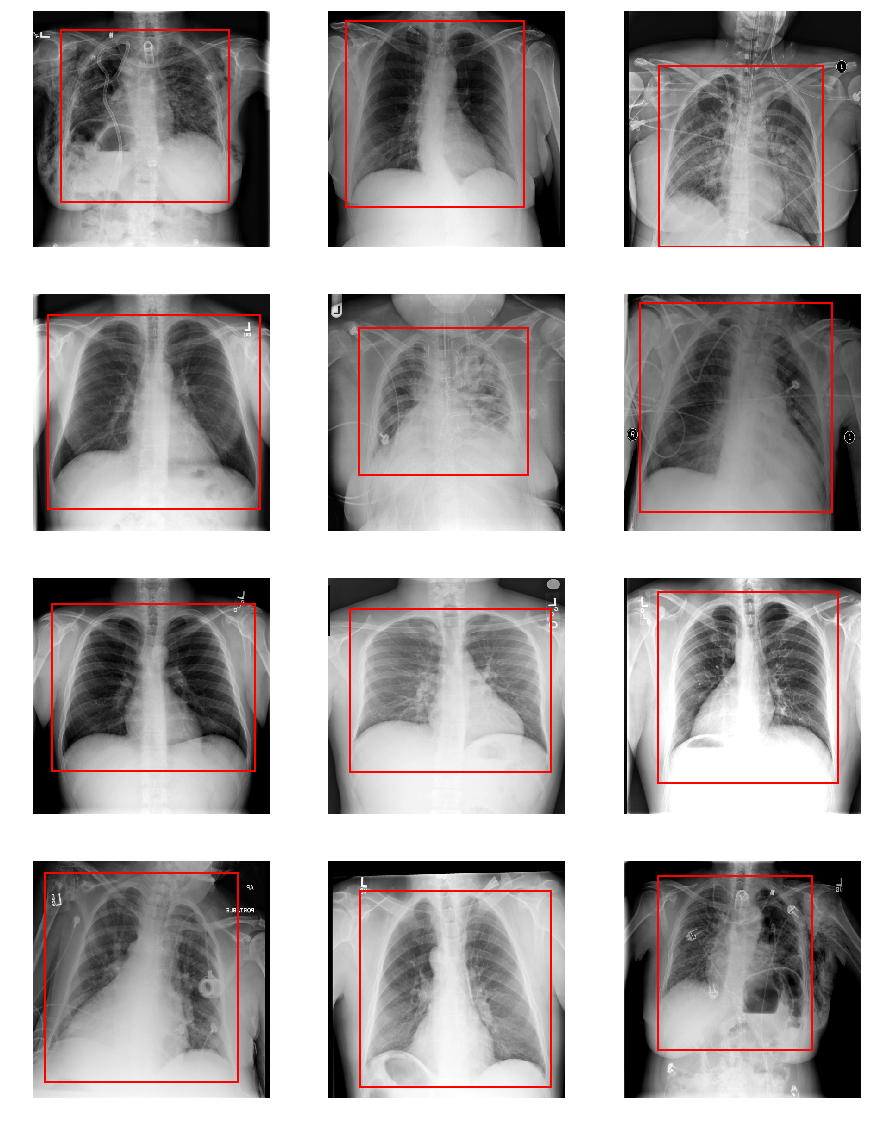

In [5]:
# sanity check (print generator images)
ModelGenerator = DataGenerator(traincsv, 
                               image_size=512,
                               batch_size=12,
                               shuffle=False)

images, labs = ModelGenerator.__getitem__(0)

max_images = 12
grid_width = 3
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*5., grid_height*5.))

for i, (im, coords) in enumerate(zip(images, labs)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,-1], cmap="gray")
    ax.add_patch(plt.Rectangle((coords[0], coords[1]), coords[2], coords[3], fill=False, edgecolor='r', linewidth=2))
    ax.axis('off')

## Localization model

In [6]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout
from keras.models import Model

def vgg_localization(input_shape=(None, None, 3)):
    
    backbone = VGG16(input_shape=input_shape, 
                     include_top=False)
    
    input = backbone.input
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(4096, activation='relu', kernel_initializer='he_normal')(x)
    output = Dense(4, kernel_initializer='he_normal')(x)
    
    model = Model(inputs=input, outputs=output)
    
    return model

## Define Loss & Metrics

In [7]:
import keras.backend as K

# define smooth L1 loss
HUBER_DELTA = 0.5
def smoothL1(y_true, y_pred):
    x   = K.abs(y_true - y_pred)
    x   = K.switch(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
    return  K.sum(x)


def iou(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou  

## Compile and training model

In [8]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

## epochs
epochs = 30

## Learning rate
learning_rate = 3e-5  

## Model Metrics
metrics = [iou]

## Define loss:: smooth L1 loss
loss = smoothL1

## batch size
batch_size = 32

## model input size
image_size = 512

## Data generator
train_generator = DataGenerator(traincsv, 
                                image_size=image_size,
                                batch_size=batch_size)

valid_generator = DataGenerator(validcsv, 
                                image_size=image_size,
                                batch_size=batch_size,
                                augmentations=get_transforms(phase='test'))

## Localization model
model = vgg_localization(input_shape=(image_size,image_size,3))

## Compile model
model.compile(loss=loss, optimizer=Adam(lr=learning_rate), metrics=metrics)

## Fit model
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator), 
                              epochs = epochs, verbose=1,
                              validation_data=valid_generator,
                              validation_steps=len(valid_generator),
                              max_queue_size=24,
                              workers=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
25/25 [==============================] - 60s 2s/step - loss: 9908.0770 - iou: 0.1837 - val_loss: 2583.1191 - val_iou: 0.6511
Epoch 2/30
25/25 [==============================] - 45s 2s/step - loss: 2163.7892 - iou: 0.6860 - val_loss: 1951.0526 - val_iou: 0.7029
Epoch 3/30
25/25 [==============================] - 46s 2s/step - loss: 1838.1679 - iou: 0.7240 - val_loss: 1819.7027 - val_iou: 0.7262
Epoch 4/30
25/25 [==============================] - 46s 2s/step - loss: 1769.5664 - iou: 0.7326 - val_loss: 1932.9540 - val_iou: 0.7056
Epoch 5/30
25/25 [==============================] - 47s 2s/step - loss: 1704.4631 - iou: 0.7408 - val_loss: 1824.1490 - val_iou: 0.7259
Epoch 6/30
25/25 [==============================] - 46s 2s/step - loss: 1570.4686 - iou: 0.7575 - val_loss: 1566.2917 - val_iou: 0.7536
Epoch 7/30
25/25 [==============================] - 46s 2s/step 

## Validation IOU across training

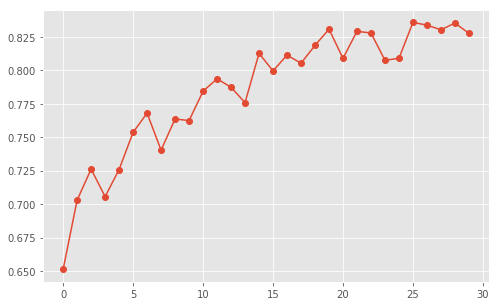

In [9]:
plt.figure(figsize=(8,5))
plt.plot(history.history['val_iou'], 'o-')

## Lets take a look at our result

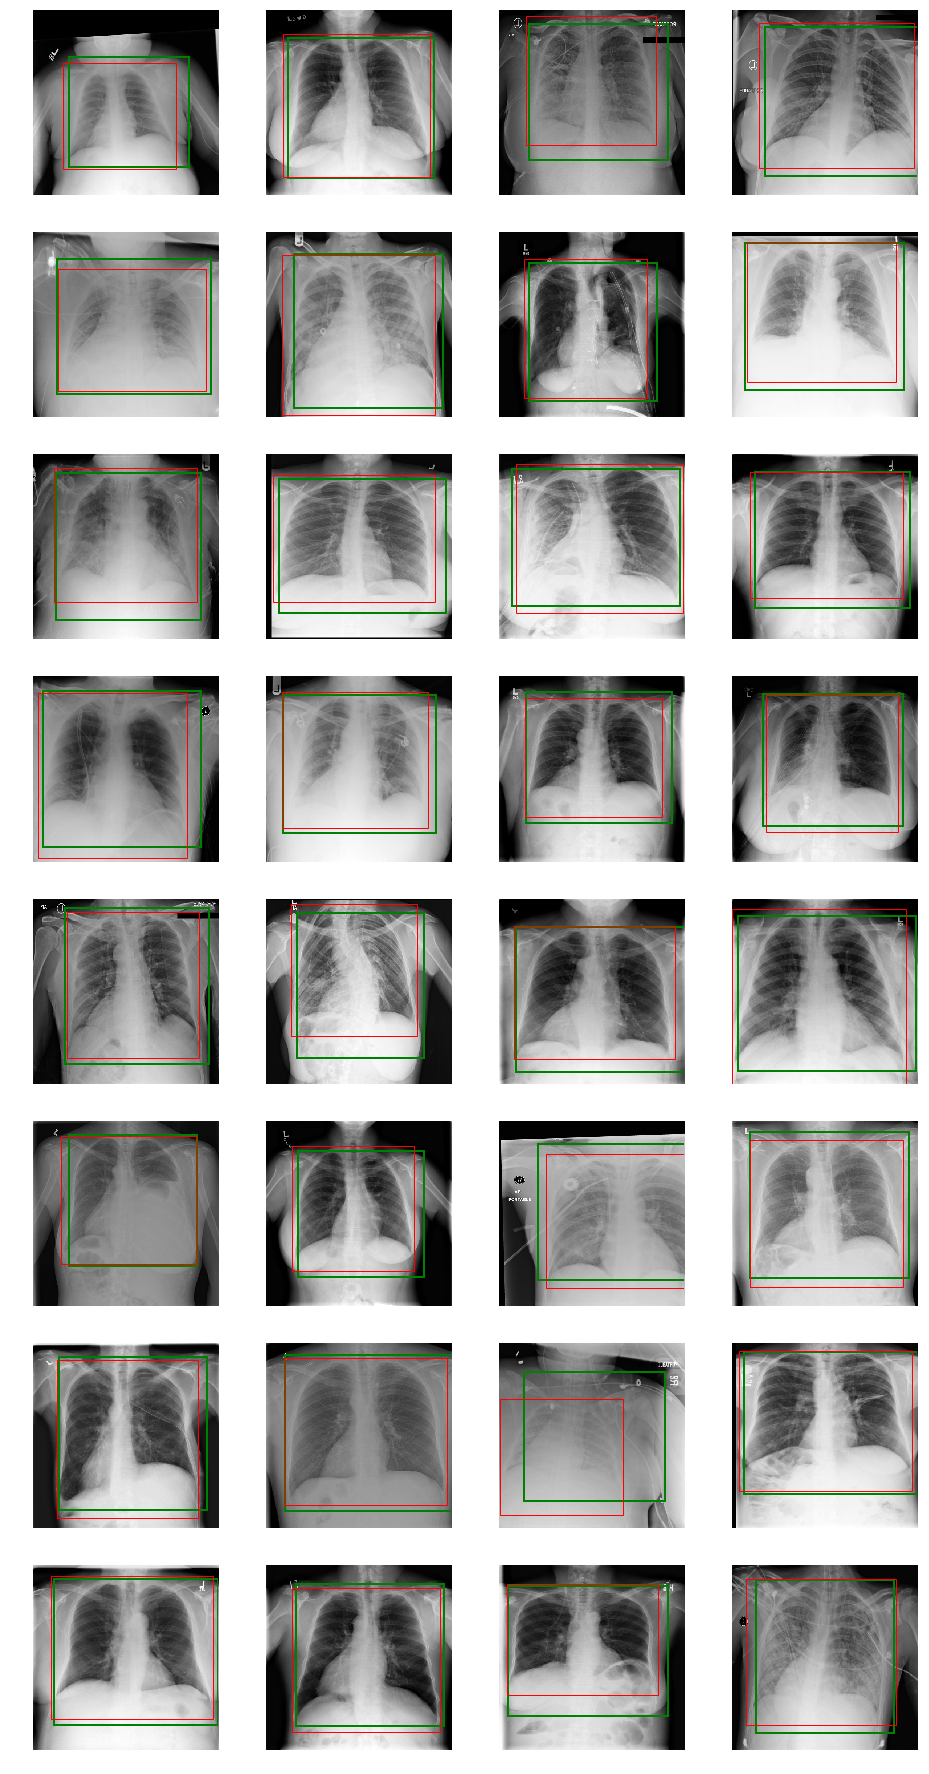

In [11]:
## get images from validation set
images, labs = valid_generator.__getitem__(1)

## get prediction
predlabs = model.predict(images)

## get plots
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4., grid_height*4.))

for i, (im, coords, pred) in enumerate(zip(images, labs, predlabs)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,-1], cmap="gray")
    ax.add_patch(plt.Rectangle((pred[0], pred[1]), pred[2], pred[3], fill=False, edgecolor='g', linewidth=2))
    ax.add_patch(plt.Rectangle((coords[0], coords[1]), coords[2], coords[3], fill=False, edgecolor='r', linewidth=1))
    ax.axis('off')